In [51]:
# 데이터 로딩 (자기 파일 위치로 바꿔서 하세요)
import pandas as pd                 # DB 분석 위한 핵심 라이브러리 -> DataFrame, Series 등 DB 구조 제공
import numpy as np                  # 수치 연산 위한 핵심 라이브러리 -> 수치 계산, 배열 연산
import matplotlib.pyplot as plt     # 시각화 위한 핵심 라이브러리 -> 그래프, 차트 그리기
import seaborn as sns               # 시각화 위한 핵심 라이브러리 -> matplolib 기반 고급 통계 시각화 라이브러리
from scipy import stats             # 통계 연산 위한 핵심 라이브러리 -> 통계 분석, 확률 분포 관련 함수들 제공
import warnings                     # 경고 메세지 제어
warnings.filterwarnings('ignore')   # 경고 메세지 무시
df = pd.read_csv(r'C:\Users\COEL_03\Desktop\CLIMAX-main\projet\데이터\train_subway21.csv', encoding='cp949')
# 컬럼명 매핑
column_mapping = {
    'train_subway21.tm': 'tm',
    'train_subway21.line': 'line',
    'train_subway21.station_number': 'station_number',
    'train_subway21.station_name': 'station_name',
    'train_subway21.direction': 'direction',
    'train_subway21.stn': 'stn',
    'train_subway21.ta': 'ta',
    'train_subway21.wd': 'wd',
    'train_subway21.ws': 'ws',
    'train_subway21.rn_day': 'rn_day',
    'train_subway21.rn_hr1': 'rn_hr1',
    'train_subway21.hm': 'hm',
    'train_subway21.si': 'si',
    'train_subway21.ta_chi': 'ta_chi',
    'train_subway21.congestion': 'congestion'
}
df = df.rename(columns=column_mapping)

print("=== 🔍 초기 데이터 확인 ===")
print(f"📊 데이터 shape: {df.shape}")       # dataframe의 크기(행, 열 수) 출력 -> f-string 사용하여 변수 값을 문자열에 삽입
print(f"📋 컬럼명: {df.columns.tolist()}")  # dataframe의 컬럼명 리스트 형태로 출력

# dataframe의 전체적인 정보 출력 (각 컬럼의 데이터 타입, 결측치 개수, 메모리 사용량 등)
print("\n📈 기본 정보:")
df.info()

# 데이터의 상위 5행 섹션 제목 출력
print("\n📄 상위 5행:")
print(df.head())

# 결측치 처리 (-99를 NaN으로 변환)
print("\n🚨 결측치 처리 중...")
weather_cols = ['rn_day', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi','ta','wd']
for col in weather_cols:
    before_count = (df[col] == -99).sum()
    df[col] = df[col].replace(-99, np.nan)
    print(f"{col}: -99 값 {before_count:,}개를 NaN으로 변환")
df['wd'] = df['wd'].replace(-9.9, np.nan)

# 결측치 비율 분석
print("\n📊 결측치 비율 분석:")
total_records = len(df)
for col in weather_cols:
    missing_count = df[col].isnull().sum()
    missing_rate = (missing_count / total_records) * 100
    print(f"{col}: {missing_count:,}개 ({missing_rate:.2f}%)")

print(f"\n전체 데이터: {total_records:,}개")
print(f"모든 기후변수가 완전한 행: {len(df[weather_cols].dropna()):,}개 ({len(df[weather_cols].dropna())/total_records*100:.2f}%)")

# 시간 변수 추출
## 현재 tm 컬럼은 년월일시간이 합쳐진 상태임. -> 시간대별 분석이 필요하기 때문에 시간 변수 추출
df['m_hr1'] = df['tm'] % 100

print(f"\n⏰ 시간 변수 추출 확인:")
print(f"tm 샘플: {df['tm'].head().tolist()}")
print(f"추출된 시간 범위: {df['m_hr1'].min()} ~ {df['m_hr1'].max()}")
print(df['m_hr1'].value_counts().sort_index())
print(f"시간 분포 (상위 10개):")
print(df['m_hr1'].value_counts().sort_index().head(10))

# 일사량 야간시간대 물리적 처리
print("\n🌙 일사량 야간시간대 처리 중...")
night_hours = [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]
night_mask = df['m_hr1'].isin(night_hours)
night_si_missing = df.loc[night_mask, 'si'].isnull().sum()
df.loc[night_mask, 'si'] = 0.0
print(f"야간시간대({night_hours}) 일사량 결측값 {night_si_missing:,}개를 0으로 설정")

# 동시 결측 패턴 확인
print("\n🔍 동시 결측 패턴 확인:")
basic_weather = ['rn_day', 'ws', 'rn_hr1', 'hm']
df['missing_count'] = df[basic_weather].isnull().sum(axis=1)
df['multiple_missing'] = df['missing_count'] >= 2
print(f"2개 이상 동시 결측: {df['multiple_missing'].sum():,}개 ({df['multiple_missing'].sum()/len(df)*100:.2f}%)")

# 변수들 대한 기술통계(평균, 표준편차, 최솟값, 최댓값 등)
print("\n📊 기본 통계:")
print(df[weather_cols + ['congestion', 'm_hr1']].describe())

# 혼잡도 관련 범위, 평균, 결측치 확인
print("\n🎯 타겟 변수 확인:")
target_col = 'congestion'
print(f"혼잡도 범위: {df[target_col].min():.2f} ~ {df[target_col].max():.2f}")
print(f"혼잡도 평균: {df[target_col].mean():.2f}")
print(f"혼잡도 결측치: {df[target_col].isnull().sum()}개")

# 날씨 변수 관련 범위 및 결측치 수
print("\n🌡️ 날씨 변수 확인:")
for col in weather_cols:
    non_null_data = df[col].dropna()
    if len(non_null_data) > 0:
        print(f"{col}: {non_null_data.min():.2f} ~ {non_null_data.max():.2f} (결측치: {df[col].isnull().sum():,}개)")
    else:
        print(f"{col}: 모든 값이 결측치")

print(f"\n📊 최종 데이터 현황:")
print(f"전체 행 수: {len(df):,}")
print(f"결측치가 없는 완전한 행 수: {len(df.dropna()):,}")

=== 🔍 초기 데이터 확인 ===
📊 데이터 shape: (5452143, 16)
📋 컬럼명: ['Unnamed: 0', 'tm', 'line', 'station_number', 'station_name', 'direction', 'stn', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'congestion']

📈 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452143 entries, 0 to 5452142
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   tm              int64  
 2   line            int64  
 3   station_number  int64  
 4   station_name    object 
 5   direction       object 
 6   stn             int64  
 7   ta              float64
 8   wd              float64
 9   ws              float64
 10  rn_day          float64
 11  rn_hr1          float64
 12  hm              float64
 13  si              float64
 14  ta_chi          float64
 15  congestion      int64  
dtypes: float64(8), int64(6), object(2)
memory usage: 665.5+ MB

📄 상위 5행:
   Unnamed: 0          tm  line  station_number station_name direction

In [15]:
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic'
print(min(df['wd']))

-9.9


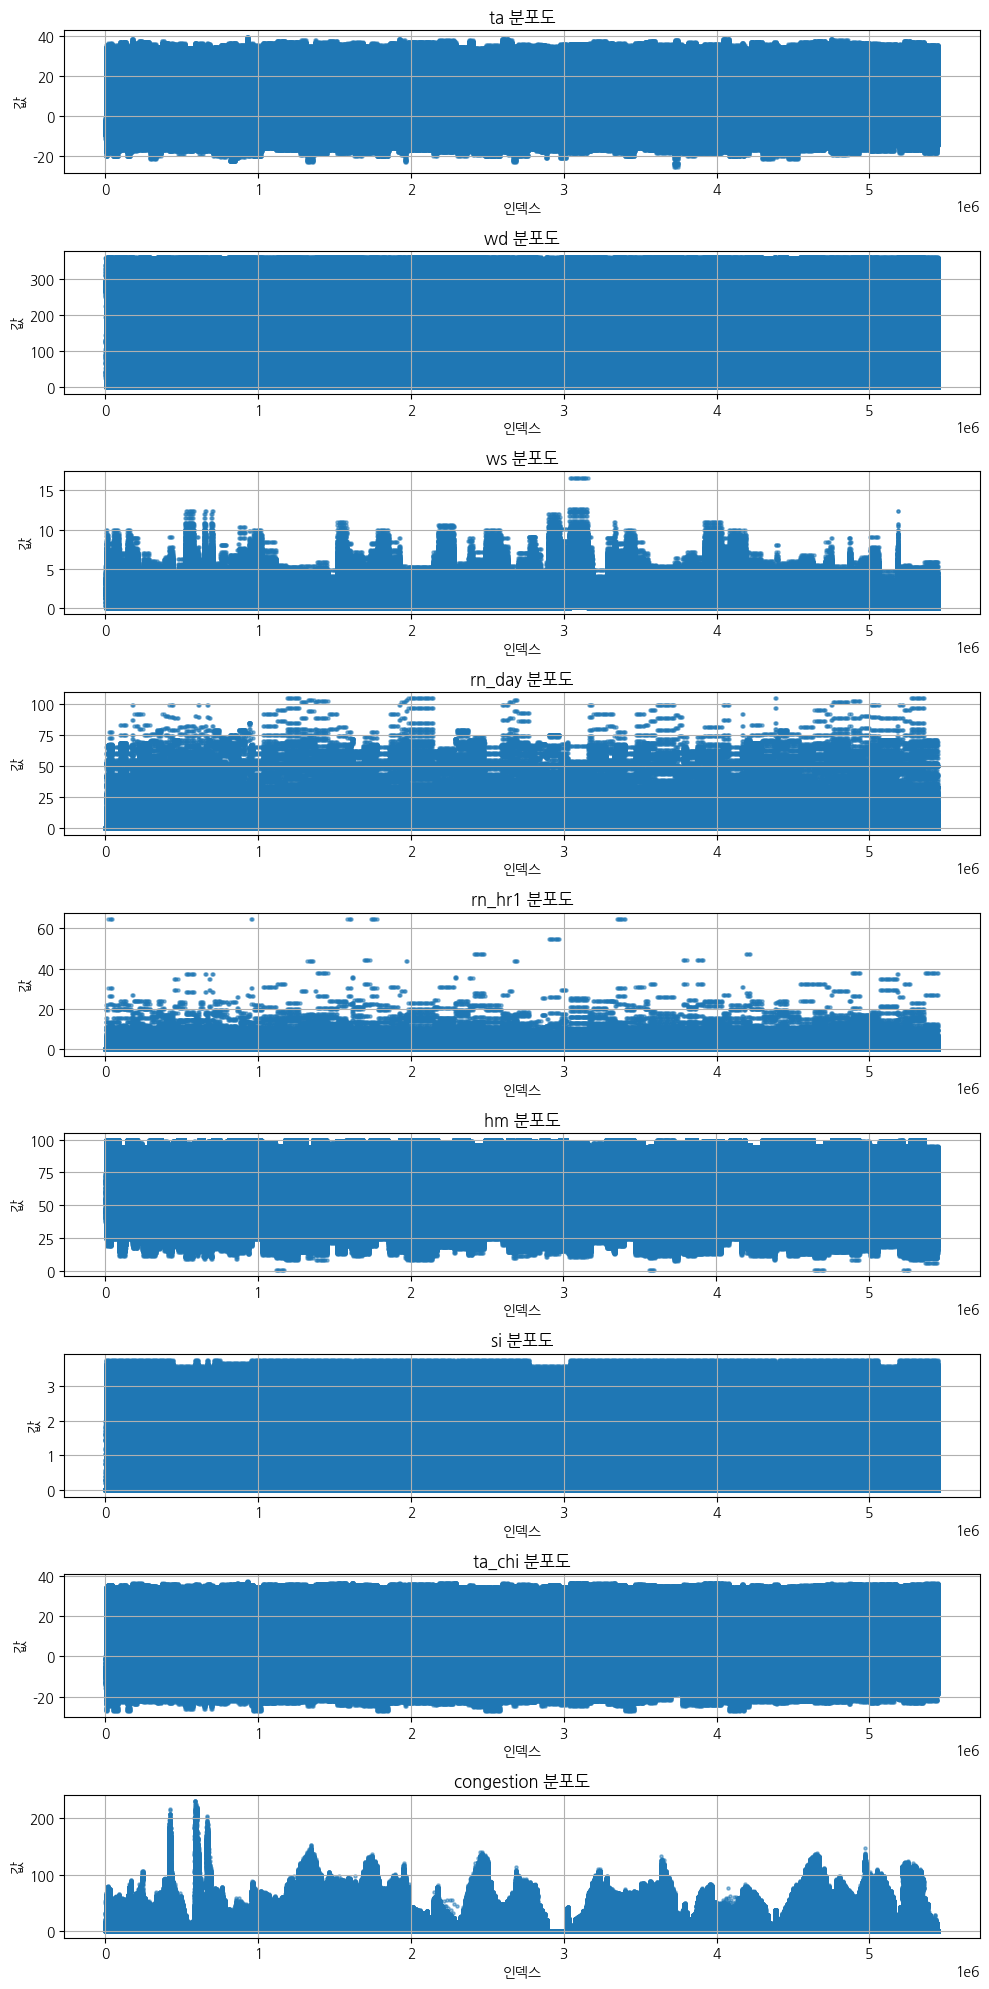

In [52]:
#결측치 확인용 코드 (이상없음)
import missingno as msno
import matplotlib.pyplot as plt
# 상대습도, 일사량, 강수량, 혼잡도 변수들의 박스플롯 시각화
columns_to_check = ['ta','wd','ws','rn_day','rn_hr1',
                    'hm','si', 'ta_chi','congestion',]
# 분포도 (산점도) 개별 출력
plt.figure(figsize=(10, 20))

for i, col in enumerate(columns_to_check):
    plt.subplot(len(columns_to_check), 1, i+1)
    plt.scatter(df.index, df[col], s=5, alpha=0.5)
    plt.title(f'{col} 분포도')
    plt.ylabel('값')
    plt.xlabel('인덱스')
    plt.grid(True)

plt.tight_layout()
plt.show()

[강남 - 여름] H1 - 기온 vs 혼잡도 상관계수: r = nan, p = nan
[강남 - 여름] H2 - 강수 vs 무강수 혼잡도 차이: t = 1.198, p = 0.2317


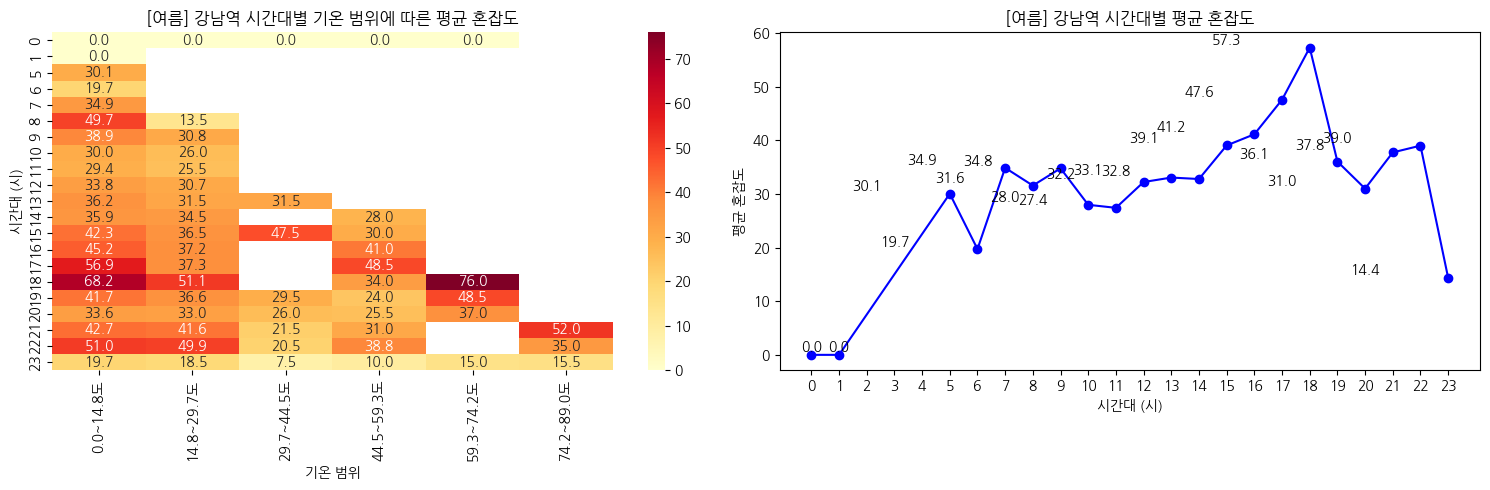

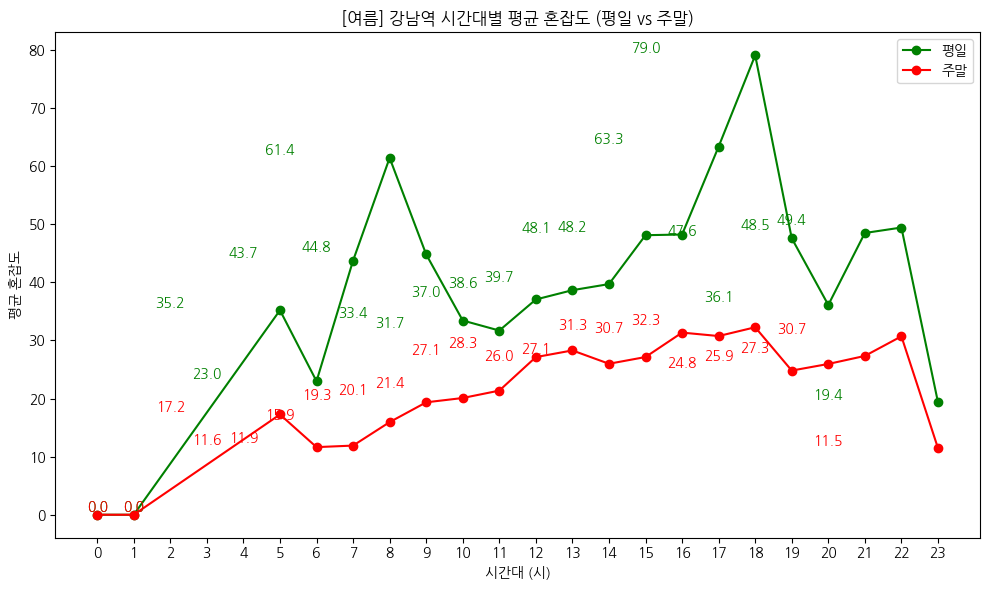

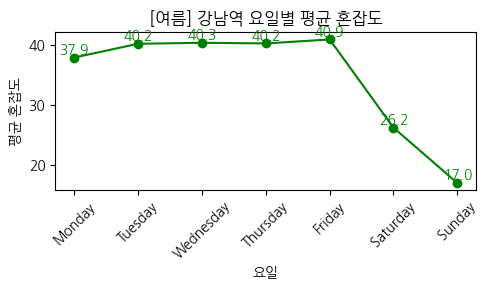

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic'


# ✅ datetime 변환 및 시간 정보 추출
df['datetime'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
df['m_hr1'] = df['datetime'].dt.hour #시간
df['month'] = df['datetime'].dt.month #달
df['dayofweek'] = df['datetime'].dt.dayofweek  # 요일 0 = 월요일, 6 = 일요일

# ✅ 2. 여름(6~8월) + 특정 역 필터링
selected_station = '강남'  # <- 원하는 역으로 바꾸면 됨
df_summer = df[(df['month'].isin([6,7,8])) & (df['station_name'] == selected_station)].copy() # 원하는 계절절

# ✅ 3. 기온 구간 설정 (min-max 기반 6등분)
ta_min = df_summer['rn_day'].min() # 여기다가 기상변수 넣기 지금은 강수량으로 되어있음음
ta_max = df_summer['rn_day'].max()
bins = np.linspace(ta_min, ta_max, 7) # 구간 설정정
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}도' for i in range(len(bins)-1)]
df_summer['temp_range'] = pd.cut(df_summer['rn_day'], bins=bins, labels=labels, include_lowest=True)

# ✅ 4. H1 - 기온 vs 혼잡도 상관계수
corr1, pval1 = pearsonr(df_summer['rn_day'], df_summer['congestion'])
print(f"[{selected_station} - 여름] H1 - 기온 vs 혼잡도 상관계수: r = {corr1:.3f}, p = {pval1:.4f}")

# ✅ 5. H2 - 강수 vs 무강수 혼잡도 차이
rain = df_summer[df_summer['rn_hr1'] > 0]['congestion']
no_rain = df_summer[df_summer['rn_hr1'] == 0]['congestion']
t_stat, t_pval = ttest_ind(rain, no_rain, equal_var=False)
print(f"[{selected_station} - 여름] H2 - 강수 vs 무강수 혼잡도 차이: t = {t_stat:.3f}, p = {t_pval:.4f}")

# ✅ 6. H3 - 시간대별 기온구간 vs 혼잡도 히트맵
pivot = df_summer.pivot_table(index='m_hr1', columns='temp_range', values='congestion', aggfunc='mean')

# 시간대별 혼잡도 히트맵
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title(f'[여름] {selected_station}역 시간대별 기온 범위에 따른 평균 혼잡도')
plt.xlabel('기온 범위')
plt.ylabel('시간대 (시)')

# 시간대별 혼잡도 그래프
plt.subplot(1, 2, 2)
pivot_mean = pivot.mean(axis=1)
pivot_mean.plot(kind='line', marker='o', color='b')
plt.title(f'[여름] {selected_station}역 시간대별 평균 혼잡도')
plt.xlabel('시간대 (시)')
plt.ylabel('평균 혼잡도')
plt.xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

# 각 점에 숫자 추가 (위쪽에 숫자 배치)
for x, y in zip(np.arange(0, 24, 1), pivot_mean):
    plt.text(x, y + 0.1, f'{y:.1f}', ha='center', va='bottom')  # 숫자를 위쪽으로 배치

plt.tight_layout()
plt.show()

# ✅ 7. 평일과 주말을 하나의 plot에 표시
df_summer['weekday'] = df_summer['dayofweek'].apply(lambda x: '평일' if x < 5 else '주말')
pivot_weekday = df_summer[df_summer['weekday'] == '평일'].pivot_table(index='m_hr1', columns='temp_range', values='congestion', aggfunc='mean')
pivot_weekend = df_summer[df_summer['weekday'] == '주말'].pivot_table(index='m_hr1', columns='temp_range', values='congestion', aggfunc='mean')

# 평일과 주말을 하나의 plot에 그리기
plt.figure(figsize=(10, 6))
pivot_weekday_mean = pivot_weekday.mean(axis=1)
pivot_weekend_mean = pivot_weekend.mean(axis=1)

# 평일과 주말 그래프 그리기
plt.plot(pivot_weekday_mean, marker='o', label='평일', color='g')
plt.plot(pivot_weekend_mean, marker='o', label='주말', color='r')
plt.title(f'[여름] {selected_station}역 시간대별 평균 혼잡도 (평일 vs 주말)')
plt.xlabel('시간대 (시)')
plt.ylabel('평균 혼잡도')
plt.xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정
plt.legend()

# 각 점에 숫자 추가 (평일, 주말)
for x, y in zip(np.arange(0, 24, 1), pivot_weekday_mean):
    plt.text(x, y + 0.1, f'{y:.1f}', ha='center', va='bottom', color='g')

for x, y in zip(np.arange(0, 24, 1), pivot_weekend_mean):
    plt.text(x, y + 0.1, f'{y:.1f}', ha='center', va='bottom', color='r')

plt.tight_layout()
plt.show()

# ✅ 8. 요일별 평균 혼잡도 (평일+주말)
# 요일 순서 고정 (월~일)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_summer['day_name'] = df_summer['datetime'].dt.strftime('%A')

# 요일을 월~일 순서대로 정렬
df_summer['day_name'] = pd.Categorical(df_summer['day_name'], categories=day_order, ordered=True)

# 요일별 평균 혼잡도 계산
daily_avg_congestion = df_summer.groupby('day_name')['congestion'].mean()


# 요일별 혼잡도 그래프
plt.figure(figsize=(5, 3))
daily_avg_congestion.plot(kind='line', marker='o', color='g')
plt.title(f'[여름] {selected_station}역 요일별 평균 혼잡도')
plt.xlabel('요일')
plt.ylabel('평균 혼잡도')
plt.xticks(rotation=45)

# 각 점에 숫자 추가 (요일별 평균 혼잡도)
for x, y in zip(np.arange(len(daily_avg_congestion)), daily_avg_congestion):
    plt.text(x, y + 0.1, f'{y:.1f}', ha='center', va='bottom', color='g')

plt.tight_layout()
plt.show()

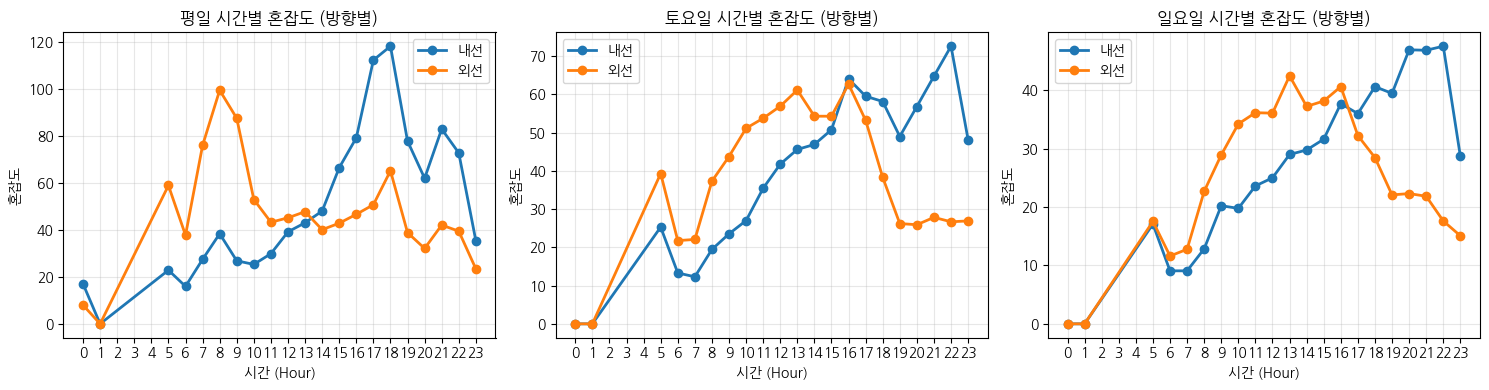

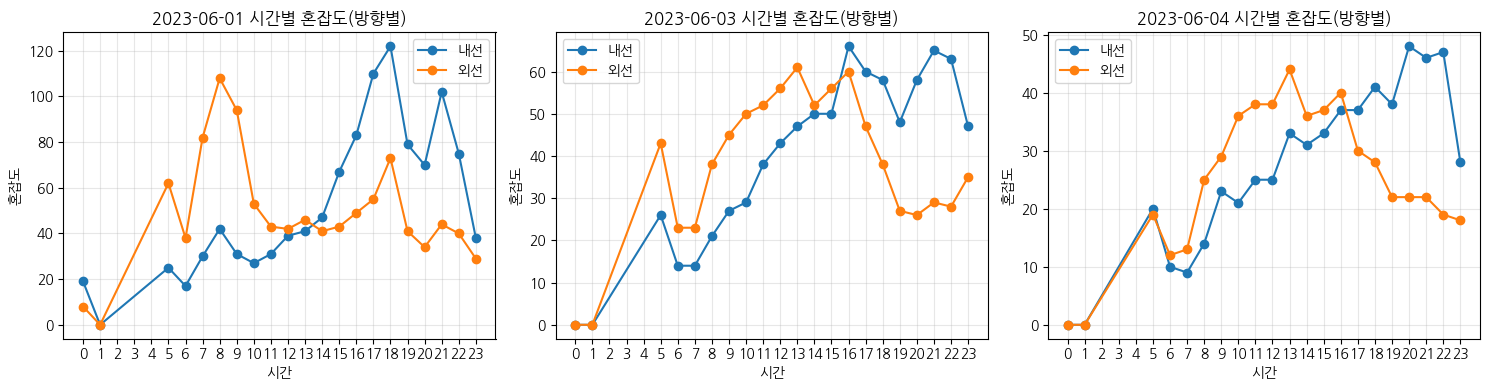


=== 요일별 방향별 평균 혼잡도 ===

평일:
  내선 평균 혼잡도: 49.53
  외선 평균 혼잡도: 46.53

토요일:
  내선 평균 혼잡도: 38.79
  외선 평균 혼잡도: 37.32

일요일:
  내선 평균 혼잡도: 26.23
  외선 평균 혼잡도: 24.67


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# 데이터 로드
result_df = pd.read_csv('../../pred_result_hour_only.csv', encoding='utf-8-sig')
result_df['datetime'] = pd.to_datetime(result_df['train_subway21.tm'], format='%Y%m%d%H%M')
result_df['date'] = result_df['datetime'].dt.date
result_df['hour'] = result_df['datetime'].dt.hour
result_df['dayofweek'] = result_df['datetime'].dt.dayofweek  # 0: 월요일, 6: 일요일

# 평일, 토요일, 일요일 시간별 혼잡도 시각화 (방향별) - Subplot으로 합치기
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 평일 시간별 혼잡도 (월~금)
weekday_df = result_df[result_df['dayofweek'].isin([0,1,2,3,4])]
for direction in ['내선', '외선']:
    direction_data = weekday_df[weekday_df['direction'] == direction]
    hourly_mean = direction_data.groupby('hour')['congestion1'].mean()
    axes[0].plot(hourly_mean.index, hourly_mean.values, marker='o', label=f'{direction}', linewidth=2)

axes[0].set_xlabel('시간 (Hour)')
axes[0].set_ylabel('혼잡도')
axes[0].set_title('평일 시간별 혼잡도 (방향별)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

# 2. 토요일 시간별 혼잡도
saturday_df = result_df[result_df['dayofweek'].isin([5])]
for direction in ['내선', '외선']:
    direction_data = saturday_df[saturday_df['direction'] == direction]
    hourly_mean = direction_data.groupby('hour')['congestion1'].mean()
    axes[1].plot(hourly_mean.index, hourly_mean.values, marker='o', label=f'{direction}', linewidth=2)

axes[1].set_xlabel('시간 (Hour)')
axes[1].set_ylabel('혼잡도')
axes[1].set_title('토요일 시간별 혼잡도 (방향별)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

# 3. 일요일 시간별 혼잡도
sunday_df = result_df[result_df['dayofweek'].isin([6])]
for direction in ['내선', '외선']:
    direction_data = sunday_df[sunday_df['direction'] == direction]
    hourly_mean = direction_data.groupby('hour')['congestion1'].mean()
    axes[2].plot(hourly_mean.index, hourly_mean.values, marker='o', label=f'{direction}', linewidth=2)

axes[2].set_xlabel('시간 (Hour)')
axes[2].set_ylabel('혼잡도')
axes[2].set_title('일요일 시간별 혼잡도 (방향별)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

plt.tight_layout()
plt.show()


# 2. 하루씩 시간별 혼잡도 비교 (방향별)
''' 전체 다 보기기
unique_dates = result_df['date'].unique()
for d in unique_dates:
    day_df = result_df[result_df['date'] == d]
    plt.figure(figsize=(10, 4))
    for direction in day_df['direction'].unique():
        dir_df = day_df[day_df['direction'] == direction]
        hourly_mean = dir_df.groupby('hour')['congestion1'].mean()
        plt.plot(hourly_mean.index, hourly_mean.values, label=f'{direction}', marker='o')
    plt.title(f'{d} 시간별 혼잡도(방향별)')
    plt.xlabel('시간')
    plt.ylabel('혼잡도')
    plt.legend()
    plt.tight_layout()
    plt.show()
'''
# 특정 날짜만 선택 (2023-06-01, 2023-06-03, 2023-06-04)
selected_dates = [datetime(2023, 6, 1).date(), datetime(2023, 6, 3).date(), datetime(2023, 6, 4).date()]

# 날짜별 시간별 혼잡도 시각화 - Subplot으로 합치기
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, d in enumerate(selected_dates):
    day_df = result_df[result_df['date'] == d]
    
    for direction in day_df['direction'].unique():
        dir_df = day_df[day_df['direction'] == direction]
        hourly_mean = dir_df.groupby('hour')['congestion1'].mean()
        axes[i].plot(hourly_mean.index, hourly_mean.values, label=f'{direction}', marker='o')
    
    axes[i].set_title(f'{d} 시간별 혼잡도(방향별)')
    axes[i].set_xlabel('시간')
    axes[i].set_ylabel('혼잡도')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

plt.tight_layout()
plt.show()

# 방향별 평균 혼잡도 출력
print("\n=== 요일별 방향별 평균 혼잡도 ===")
for day_name, day_numbers in [("평일", [0,1,2,3,4]), ("토요일", [5]), ("일요일", [6])]:
    day_df = result_df[result_df['dayofweek'].isin(day_numbers)]
    print(f"\n{day_name}:")
    for direction in ['내선', '외선']:
        direction_mean = day_df[day_df['direction'] == direction]['congestion1'].mean()
        print(f"  {direction} 평균 혼잡도: {direction_mean:.2f}") 



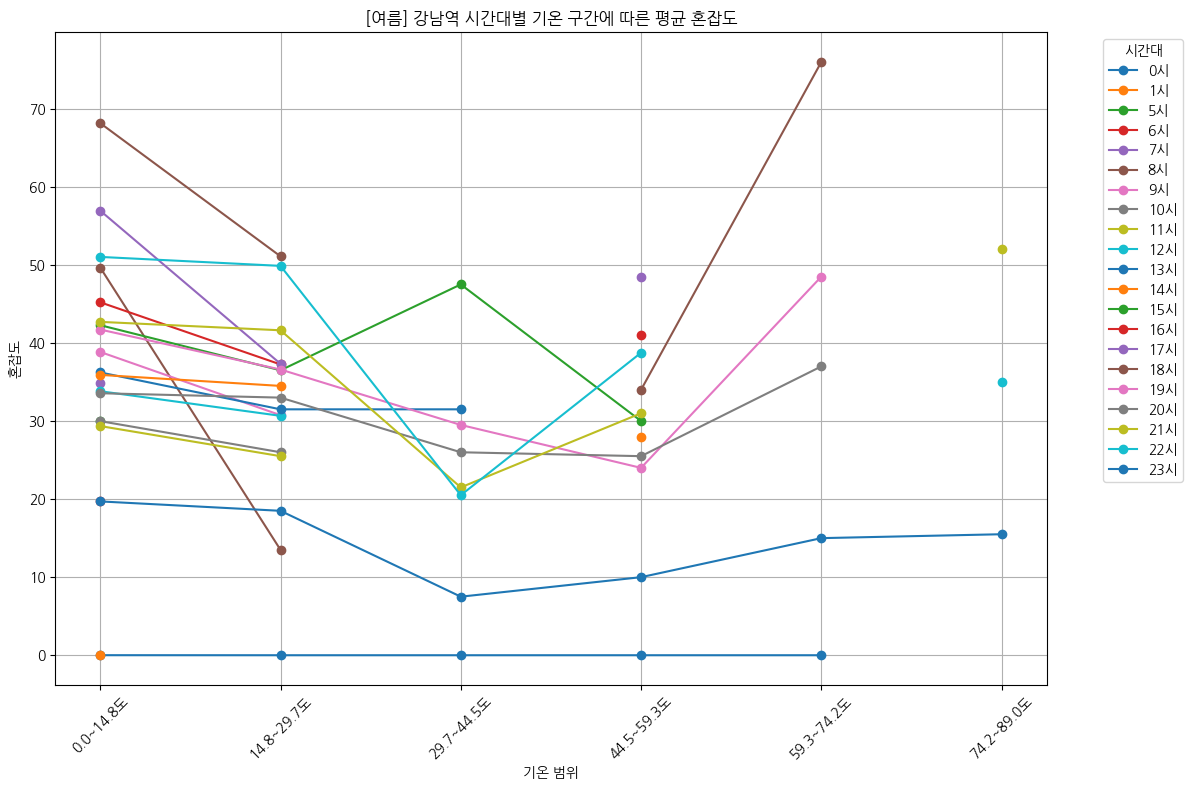

In [55]:
# ✅ 7. 시간대별 기온구간 vs 혼잡도 선그래프 #여기서 기상변수에 따른 혼잡도를 봐줘야함줘야함
unique_hours = sorted(df_summer['m_hr1'].unique())
plt.figure(figsize=(12, 8))
for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr]
    avg_by_temp = sub.groupby('temp_range')['congestion'].mean()
    plt.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")

plt.title(f"[여름] {selected_station}역 시간대별 기온 구간에 따른 평균 혼잡도")
plt.xlabel("기온 범위")
plt.ylabel("혼잡도")
plt.legend(title='시간대', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [56]:
# ✅ 7. 시간대별 강수량 vs 혼잡도 상관계수 (Pearson + Spearman) #여기도기도
from scipy.stats import pearsonr, spearmanr, ttest_ind

print(f"\n📊 [{selected_station}] 시간대별 강수량 vs 혼잡도 상관계수 (선형/비선형)")
print("=" * 60)
unique_hours = sorted(df_summer['m_hr1'].unique())
for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][['rn_day', 'congestion']].dropna()
    if len(sub) >= 2:
        r_pear, p_pear = pearsonr(sub['rn_day'], sub['congestion'])
        r_spear, p_spear = spearmanr(sub['rn_day'], sub['congestion'])
        print(f"{hr}시 (n={len(sub)}): Pearson r = {r_pear:.3f}, p = {p_pear:.4f} | Spearman ρ = {r_spear:.3f}, p = {p_spear:.4f}")
    else:
        print(f"{hr}시: 데이터 부족 (n={len(sub)})")


📊 [강남] 시간대별 강수량 vs 혼잡도 상관계수 (선형/비선형)
0시 (n=178): Pearson r = -0.033, p = 0.6577 | Spearman ρ = -0.061, p = 0.4224
1시 (n=184): Pearson r = nan, p = nan | Spearman ρ = nan, p = nan
5시 (n=182): Pearson r = -0.100, p = 0.1809 | Spearman ρ = -0.119, p = 0.1096
6시 (n=182): Pearson r = -0.129, p = 0.0830 | Spearman ρ = -0.097, p = 0.1944
7시 (n=180): Pearson r = -0.158, p = 0.0341 | Spearman ρ = -0.119, p = 0.1120
8시 (n=178): Pearson r = -0.113, p = 0.1324 | Spearman ρ = -0.084, p = 0.2651
9시 (n=178): Pearson r = -0.081, p = 0.2815 | Spearman ρ = -0.059, p = 0.4356
10시 (n=176): Pearson r = -0.040, p = 0.6021 | Spearman ρ = -0.008, p = 0.9109
11시 (n=178): Pearson r = -0.063, p = 0.4044 | Spearman ρ = -0.007, p = 0.9266
12시 (n=178): Pearson r = -0.033, p = 0.6597 | Spearman ρ = 0.052, p = 0.4934
13시 (n=178): Pearson r = -0.089, p = 0.2400 | Spearman ρ = -0.003, p = 0.9719
14시 (n=178): Pearson r = -0.075, p = 0.3175 | Spearman ρ = 0.000, p = 0.9952
15시 (n=178): Pearson r = -0.048, p = 0.5213 | S

In [57]:
# Pearson 상관 분석 (결측치를 동시에 삭제하여 두 변수 길이 맞추기)
print("📊 Pearson 상관 계수 (기상 변수 vs 혼잡도):")
for col in weather_cols:
    # 두 변수에서 결측치가 있는 행을 동시에 제거
    valid_data = df[['congestion', col]].dropna()
    corr, p_val = pearsonr(valid_data[col], valid_data['congestion'])
    print(f"{col} vs 혼잡도: Pearson r = {corr:.3f}, p-value = {p_val:.4f}")

# Spearman 상관 분석 (결측치를 동시에 삭제하여 두 변수 길이 맞추기)
print("\n📊 Spearman 상관 계수 (기상 변수 vs 혼잡도):")
for col in weather_cols:
    # 두 변수에서 결측치가 있는 행을 동시에 제거
    valid_data = df[['congestion', col]].dropna()
    corr, p_val = spearmanr(valid_data[col], valid_data['congestion'])
    print(f"{col} vs 혼잡도: Spearman ρ = {corr:.3f}, p-value = {p_val:.4f}")


📊 Pearson 상관 계수 (기상 변수 vs 혼잡도):
rn_day vs 혼잡도: Pearson r = -0.027, p-value = 0.0000
ws vs 혼잡도: Pearson r = 0.040, p-value = 0.0000
rn_hr1 vs 혼잡도: Pearson r = -0.013, p-value = 0.0000
hm vs 혼잡도: Pearson r = -0.125, p-value = 0.0000
si vs 혼잡도: Pearson r = 0.108, p-value = 0.0000
ta_chi vs 혼잡도: Pearson r = 0.063, p-value = 0.0000
ta vs 혼잡도: Pearson r = 0.071, p-value = 0.0000
wd vs 혼잡도: Pearson r = 0.021, p-value = 0.0000

📊 Spearman 상관 계수 (기상 변수 vs 혼잡도):
rn_day vs 혼잡도: Spearman ρ = -0.005, p-value = 0.0000
ws vs 혼잡도: Spearman ρ = 0.111, p-value = 0.0000
rn_hr1 vs 혼잡도: Spearman ρ = -0.025, p-value = 0.0000
hm vs 혼잡도: Spearman ρ = -0.183, p-value = 0.0000
si vs 혼잡도: Spearman ρ = 0.305, p-value = 0.0000
ta_chi vs 혼잡도: Spearman ρ = 0.092, p-value = 0.0000
ta vs 혼잡도: Spearman ρ = 0.102, p-value = 0.0000
wd vs 혼잡도: Spearman ρ = 0.026, p-value = 0.0000


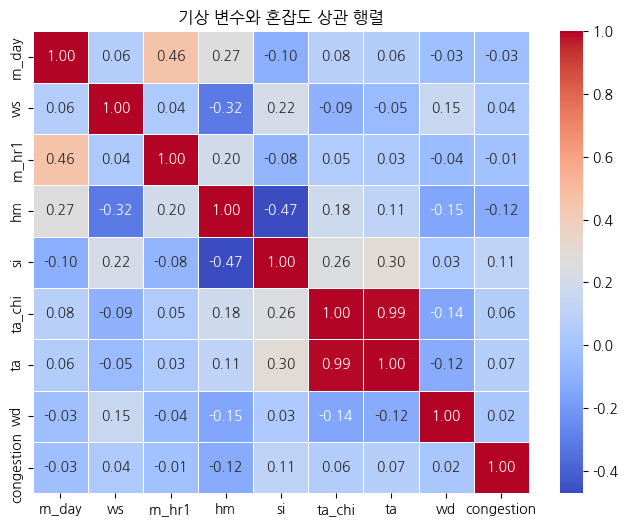

In [58]:
# 상관 행렬 시각화
correlation_matrix = df[weather_cols + ['congestion']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("기상 변수와 혼잡도 상관 행렬")
plt.show()
